### Formula:

$$
ln(\frac{P_H}{1-P_H}) = \beta_0 + X^Tw
$$

where $\beta_0$ is a scalar bias term, $x$ is a vector of the 10 successive time windows (100ms each) over the trial, and $w$ is a vector of the weights for each time window.

For my case, $ln(\frac{P_H}{1-P_H})$ can be substituted by the binary choice vector.

In [1]:
from djchurchland import *
from djchurchland.schema import * # Imports all schemas from the database
from djchurchland.utils import *
from djchurchland.chipmunk.psychometric import PsychometricFit
from chiCa.chiCa import separate_axes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

# save_dir = '/Users/gabriel/Desktop/BSN_figures/'

%matplotlib widget
%load_ext autoreload
%autoreload 2

[2025-08-18 22:27:11,198][INFO]: Connecting gabriel@localhost:3306
[2025-08-18 22:27:11,250][INFO]: Connected gabriel@localhost:3306


### Logic of psychophysical kernel
1. Grab n number of sessions
2. Fetch the choices and stimulus timestamps for those n sessions
3. Calculate the residual rate for every trial in every session
4. Concatenate across sessions
5. Fit a cross-validated logistic regression model where X are the residual rates and y are the choices for every group of sessions
6. Fetch the weights that represent each moment in time in the stimulus window from the fitted model. The value of these weights refers to how heavily mice weigh sensory evidence presented at this time bin.

### Setting up the design matrix for the logistic regression
1. Fetch the session IDs for sessions I want to calculate a kernel on. These sessions should ideally be good performing sessions with various stimulus intensities. Perhaps one place to start would be the sessions that I calculated a psychometric fit for.
2. Construct a query that fetches the stimulus timestamps and choices for every trial. These should be in Chipmunk.Trial().
3. Create a `bins` linspace array that starts with the first stimulus timestamp in a trial and ends with the last but make sure `num` is `timebins+1`.
4. Calculate the specific rate (SR) which will be `20/len(bins)`, 20 because that's the highest rate we can have.
5. Calculate the instantaneous rate (IR) or counts per bin for the trial by doing `IR, _ = np.histogram(stimulus_timestamps_per_trial, bins=bins)`.
6. Calculate the residual rate by doing `residual = IR-SR`.
7. Concatenate the residuals and the choices across sessions. The final array should be n_total_trials x timebins.

In [170]:
subject_name = "GRB036"
sessions_back = 50
session_ids = (SessionRun() & f'subject_name="{subject_name}"').fetch('session_datetime', limit=sessions_back, order_by='-session_datetime') #grab session datetimes for last n sessions
trials = (Chipmunk.Trial() & f'subject_name="{subject_name}"' & [{'session_datetime': dt} for dt in session_ids] & 'with_choice = 1')
stim_ts = trials.fetch("stimulus_event_timestamps") #stim_ts is n_trials long and in every trial there is an array of n_stimuli presented in that trial
choices = trials.fetch('response') #right is -1, left is 1
choices = (choices == -1).astype(int) #now right is 1 and left is 0

timebins = 10 #number of columns to have in our design matrix
residual = np.zeros((len(choices), timebins))
for trial, stimuli in enumerate(stim_ts):
    bins = np.linspace(stimuli[0], stimuli[-1], num=timebins+1)
    SR = 20/len(bins) #SR = specific rate; 20 because that's the highest rate we can have
    IR, _ = np.histogram(stimuli, bins=bins) #IR = instantaneous rate or counts per bin in this case
    residual[trial] = IR-SR #this is the residual rate

### Performing the regression
1. Residuals are `X` and choices are `y`.
2. Set up stratified Kfolds object with `shuffle=True` and `n_splits=10`.
3. Set up lists to store the weights, scores, biases, and errors.
4. Set up `for loop` where for every `train_idx, text_idx in kf.split(X, y)` you fit a LogisticRegression model with an `l2` penalty.
5. Calculate the error by calculating the covariance matrix of the `np.product` of the `model.predict_proba(X_train)` along the 1st axis. Then, the error is calculated by taking the saquare root of the diagonal of the covariance matrix.
6. Store the weights, scores, biases, and errors by appending them to the list at the end of the Kfolds loop.

Design matrix shape: (8057, 10)
Predictor vector shape: (8057,)
Mean cross-validated score: 0.7979381347964798
Mean intercept value: 1.5301240657746435


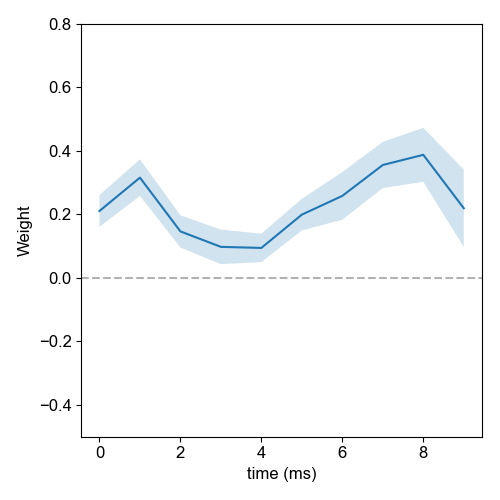

In [171]:
X = residual
y = choices
cv = 10

kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
weight_list = []
score_list = []
bias_list = []
err_list = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
    model = LogisticRegression(penalty='l2', solver='liblinear', C=1, fit_intercept=True).fit(X_train, Y_train)

    predict_prob = model.predict_proba(X_train)
    V = np.product(predict_prob, axis=1)
    covariance_mat = np.linalg.pinv(np.dot(X_train.T*V, X_train))

    standard_err = np.sqrt(np.diag(covariance_mat))
    err_list.append(standard_err)

    weight = model.coef_[0]
    weight_list.append(weight)

    score = model.score(X_test, Y_test)
    score_list.append(score)

    bias = model.intercept_
    bias_list.append(bias)

res = {'X':X, 'y':y, 'weights':weight_list, 'scores':score_list, 'bias':bias_list, 'error':err_list}

print(f"Design matrix shape: {res['X'].shape}")
print(f"Predictor vector shape: {res['y'].shape}")
print('Mean cross-validated score:', np.mean(res['scores']))
print('Mean intercept value:', np.mean(res['bias']))

weights_avg = np.mean(weight_list, axis=0)
weights_err = np.mean(err_list, axis=0)

plt.figure(figsize=(5, 5))
plt.plot(weights_avg)
plt.fill_between(range(len(weights_avg)), weights_avg - weights_err, weights_avg + weights_err, alpha=0.2)
plt.ylabel('Weight')
plt.xlabel('time (ms)')
plt.ylim([-0.5, 0.8])
plt.axhline(0, color='k', alpha=0.3, linestyle='--')

# tick_500ms = int(timebins * 500 / 1000)  # Position of the 500ms tick
# tick_1000ms = int(timebins * 1000 / 1000)  # Position of the 1000ms tick

# plt.xticks([0, tick_500ms, tick_1000ms], ['0', '500', '1000'])

# separate_axes(plt.gca())
plt.tight_layout()